In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import ipywidgets as widgets

In [7]:
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

df = pd.read_csv(
    'tweets.csv',
    encoding='ISO-8859-1',
    header=None,
    names=column_names,
    on_bad_lines='skip'
)

print(df.head())

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [8]:
df.drop(columns=['ids', 'date', 'flag', 'user'], inplace=True)

In [9]:
df.rename(columns={'target': 'label'}, inplace=True)

In [10]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
df["label"].value_counts()

,count
label,
0,800000
4,800000


In [12]:
df['label'] = df['label'].replace({0: 'negative', 4: 'positive'})

In [13]:
df["label"].value_counts()

,count
label,
negative,800000
positive,800000


In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [15]:
label_0_samples = df[df['label'] == 0].sample(n=100000, random_state=42)
label_1_samples = df[df['label'] == 1].sample(n=100000, random_state=42)


df = pd.concat([label_0_samples, label_1_samples]).reset_index(drop=True)

df = df.sample(frac=1).reset_index(drop=True)

In [16]:
print(df.isna().sum())
print(df.duplicated().sum())

label    0
text     0
dtype: int64
832


In [17]:
df.shape

(200000, 2)

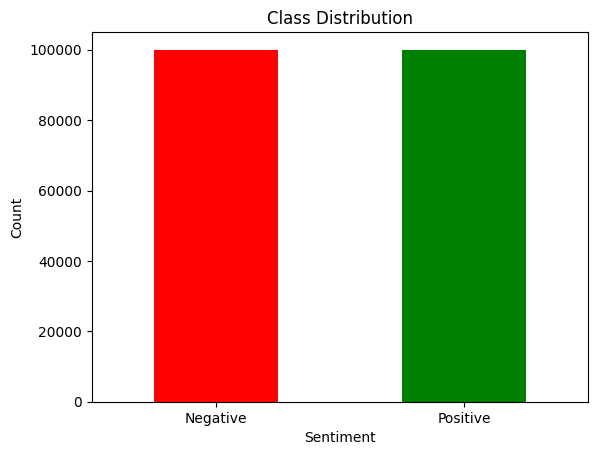

In [42]:
df['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

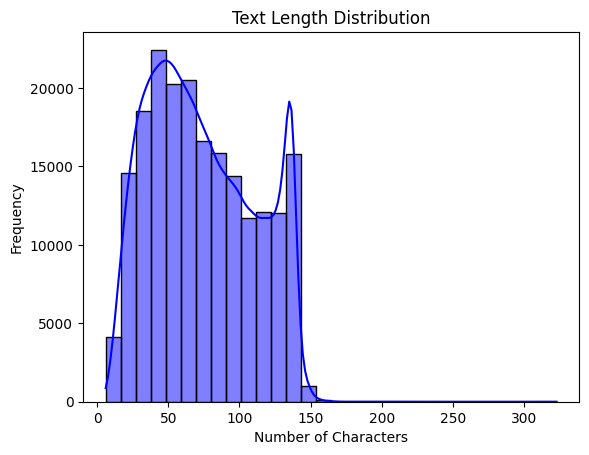

In [41]:
df['text_length'] = df['text'].apply(len)
sns.histplot(df['text_length'], kde=True, bins=30, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

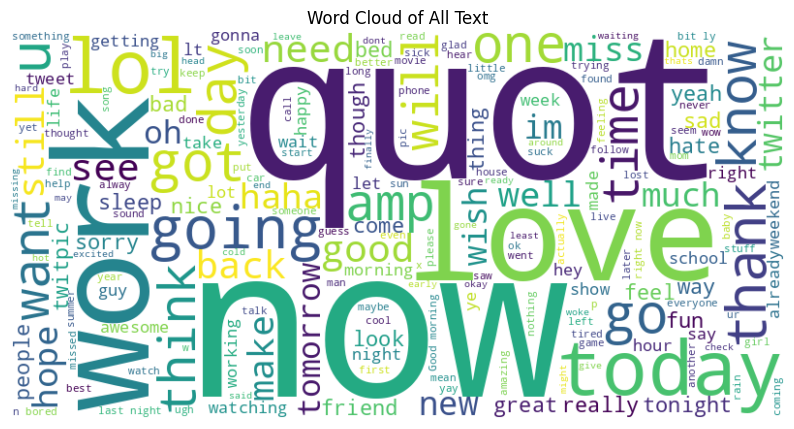

In [43]:
from wordcloud import WordCloud

all_text = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()

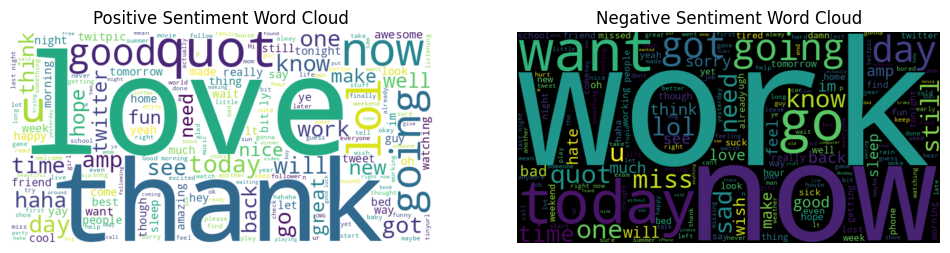

In [47]:
positive_text = ' '.join(df[df['label'] == 1]['text'])
negative_text = ' '.join(df[df['label'] == 0]['text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


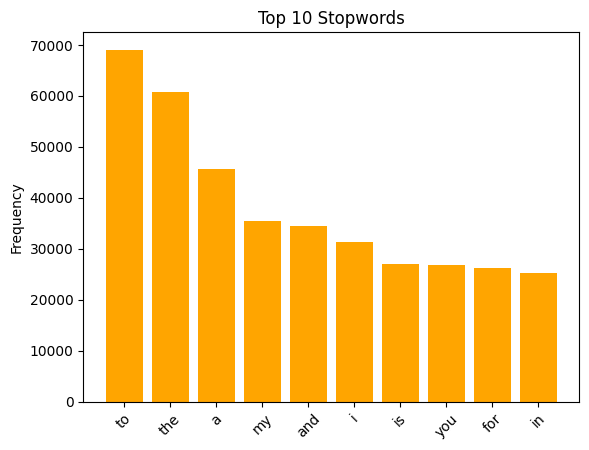

In [44]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stopword_counts = Counter(word for text in df['text'] for word in text.split() if word in stop_words)
most_common_stopwords = stopword_counts.most_common(10)

words, counts = zip(*most_common_stopwords)
plt.bar(words, counts, color='orange')
plt.title('Top 10 Stopwords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [20]:
def preprocess_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [PorterStemmer().stem(word) for word in tokens if word.isalnum() and word not in stopwords.words('english')]

    return " ".join(tokens)

In [21]:
df['Processed_Text'] = df['text'].apply(preprocess_text)

In [22]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Processed_Text'])
y = df['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

MultinomialNB()

In [25]:
accuracy = naive_bayes_model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.75


In [37]:
from sklearn.metrics import classification_report

y_pred = naive_bayes_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.74      0.79      0.76     20181
    Positive       0.77      0.72      0.74     19819

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



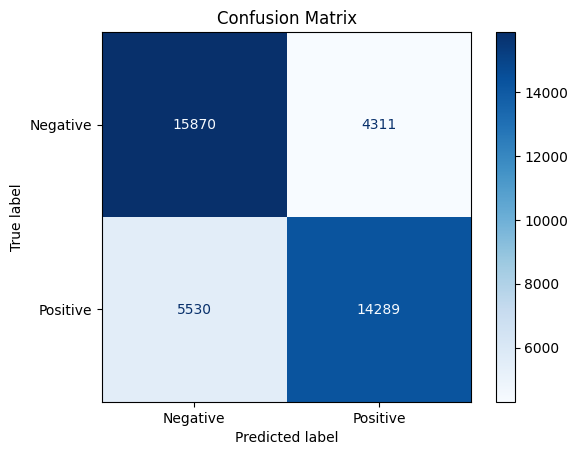

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [39]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(naive_bayes_model, X, y, cv=5)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f}')

Cross-Validation Accuracy: 0.75


In [26]:
import joblib

In [27]:
joblib.dump(naive_bayes_model, 'sentiment_analysis_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']